For each question, make sure to:

State your Null Hypothesis and Alternative Hypothesis

Select the correct test according to the data type and number of samples

Test the assumptions of your selected test.

Execute the selected test, or the alternative test (if you do not meet the assumptions)

Interpret your p-value and reject or fail to reject your null hypothesis

Show a supporting visualization that helps display the result.

In [68]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [69]:
df = pd.read_csv('Data/insurance - insurance.csv')
df = df.drop_duplicates()
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


<AxesSubplot:xlabel='smoker', ylabel='charges'>

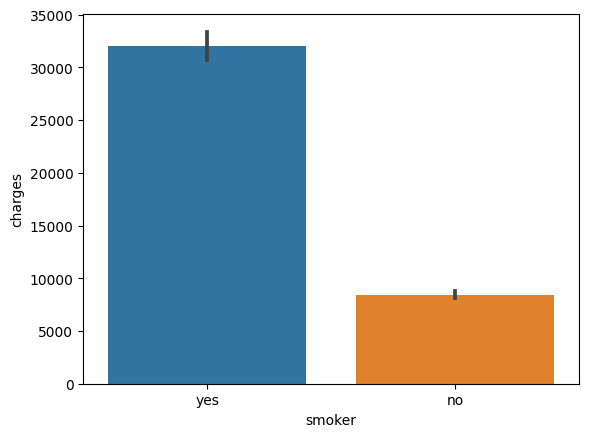

In [70]:
sns.barplot(data=df, x='smoker', y='charges')

In [71]:
# seperate smokers from non-smokers
df_smoker = df[df['smoker']=='yes']
df_nonsmoker = df[df['smoker']=='no']

# Q1. Do smokers have higher insurance charges than non-smokers?

## Stating Hypothesis

H0 -> There is no difference between smokers and non smokers regarding insurance charges.

H1 -> There is a difference between smokers and non-smokers in insurance charges.

Data Type : Numeric

Samples: 2 samples/groups

Test : 2 Sample T-Test

Assumptions : No significant outliers - Normality - Equal Variance 

In [72]:
# seperate smoker charges from non-smoker charges
smoker_charges = df_smoker['charges']
nonsmoker_charges = df_nonsmoker['charges']

smoker_charges

0       16884.92400
11      27808.72510
14      39611.75770
19      36837.46700
23      37701.87680
           ...     
1313    36397.57600
1314    18765.87545
1321    28101.33305
1323    43896.37630
1337    29141.36030
Name: charges, Length: 274, dtype: float64

In [73]:
# Check for outliers in weight for strength group
smoker_zscores= stats.zscore(smoker_charges)
smoker_outliers = abs(smoker_zscores)>3
print(np.sum(smoker_outliers))

non_zscores= stats.zscore(nonsmoker_charges)
non_outliers = abs(non_zscores)>3
print(np.sum(non_outliers))

0
24


In [74]:
# remove outliers
print(len(nonsmoker_charges))
nonsmoker_charges = nonsmoker_charges[non_outliers == False] 
print(len(nonsmoker_charges))

1063
1039


In [75]:
# check for normality
result = stats.normaltest(smoker_charges)
result

NormaltestResult(statistic=61.03941356533816, pvalue=5.564930630036463e-14)

normal test indicates that the data is not a normal distribution.

In [76]:
# check for normality
result = stats.normaltest(nonsmoker_charges)
result


NormaltestResult(statistic=163.70821423990097, pvalue=2.8262654970074626e-36)

normal test indicates that the data is not a normal distribution.

Despite both test showing not normal distibutions we can ignore assumption because we have a larger then n>15

In [77]:
# levenes test
result = stats.levene(smoker_charges, nonsmoker_charges)
result

LeveneResult(statistic=520.7178262969225, pvalue=2.512613039096279e-97)

non equal variance

In [78]:
result = stats.ttest_ind(smoker_charges, nonsmoker_charges, equal_var=False)
result

Ttest_indResult(statistic=33.723466247187815, pvalue=2.7282718648018296e-104)

we reject the null hypothesis 

32050.23183153284 7945.9246538585185


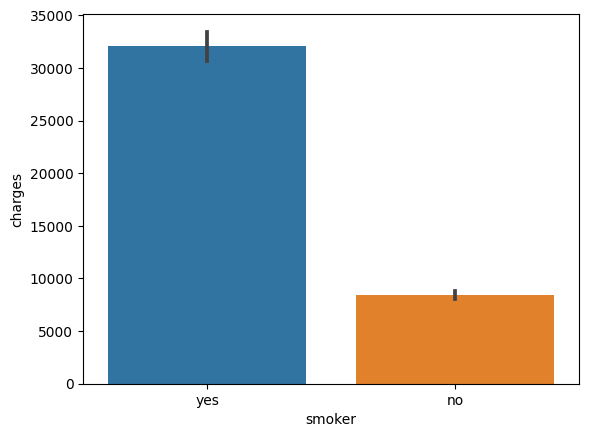

In [79]:
sns.barplot(data=df, x='smoker', y='charges')
print(smoker_charges.mean(),nonsmoker_charges.mean())

# Q2. Are men more likely to smoke than women?

## Stating Hypothesis
H0 -> Men and women are equally likely to be smokers.

H1 -> There is a difference between Men and women in there likelyhood of being a smoker. 

Data Type : Categorical

Sample : 2 samples/groups

Test : Chi-Square

Assumptions : There are two categorical variables (ordinal or nominal) and
their outcomes are independent.

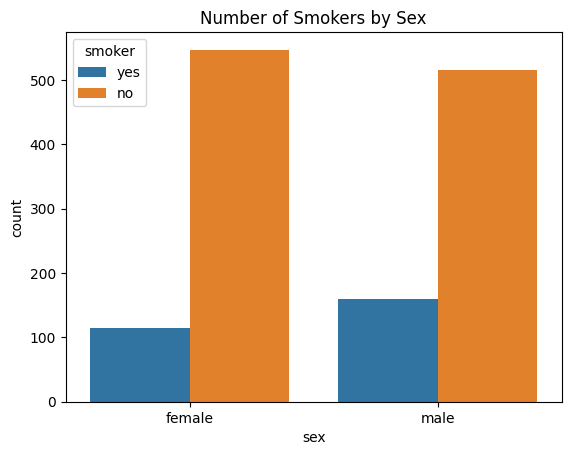

In [80]:
ax = sns.countplot(data=df, x='sex',hue='smoker')
ax.set_title("Number of Smokers by Sex");


In [81]:
# calculate the contingency table with pd.cross-tab
table = pd.crosstab(df['smoker'], df['sex'])
table

sex,female,male
smoker,,
no,547,516
yes,115,159


In [82]:
# Run the Test and Save the Output
result = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = result #this labels the results
p

0.0062765550120107375

because we have a significant p value we reject our null hypothesis. we conclude that there is a difference between males and female smokers

In [83]:

table = pd.crosstab(df['smoker'], df['sex'], normalize='columns')
table

sex,female,male
smoker,,
no,0.826284,0.764444
yes,0.173716,0.235556


# Q3. Do different regions have different charges, on average?


## Stating Hypothesis
H0 -> There is no difference in charges between regions.

H1 -> There is a difference in charges, on average, between regions.

Data Type : Numerical

Sample : More than 2 samples/groups

Test : ANOVA and/or Tukey

Assumptions : No significant outliers - Equal variance -Normality

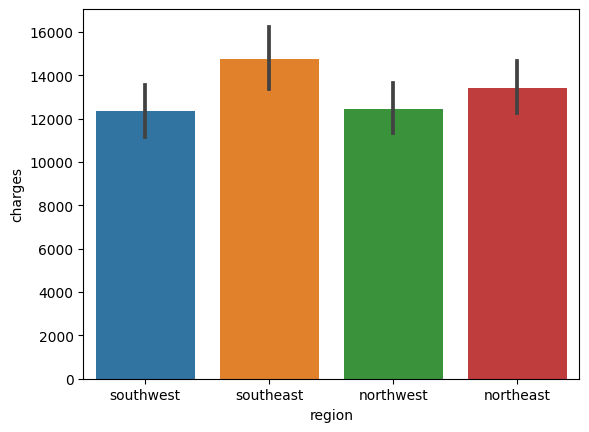

In [84]:
sns.barplot(data=df, x='region',y='charges');

In [85]:
## Create groups dictionary. There are only 3 groups, but this is even more helpful when there are many groups
groups = {}
## Loop through all unique categories
for i in df['region'].unique():
    ## Get series for group and rename
    data = df.loc[df['region']==i,'charges'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

In [87]:
clean_groups = {}

for i, j in groups.items():
    # Find the outliers 
    idx_outliers = np.abs(stats.zscore(j))>3
    
    # display how many there are
    print("Number of outliers : ", idx_outliers.sum())
    
    # store which rows are outliers and which aren't
    temp = j[idx_outliers==False]
    
    #combine with original dict
    clean_groups[i] = temp

Number of outliers :  8
Number of outliers :  2
Number of outliers :  7
Number of outliers :  4


In [89]:
## Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for i, data in clean_groups.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data), 'p':p, 'test stat':stat}
    
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T

### checking sig with pandas 
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df

,n,p,test stat,sig
southwest,317.0,7.728611e-22,97.223886,True
southeast,362.0,1.936990e-13,58.544942,True
northwest,317.0,3.547435e-19,84.965784,True
northeast,320.0,3.557877e-17,75.749565,True


In [90]:
# with the * operator 
stats.levene(*groups.values())
# we reject the null hyp. and the data is not equal variance

LeveneResult(statistic=5.553479860699911, pvalue=0.0008689544824002284)

In [91]:
# perform the correct hypothesis test
result = stats.f_oneway( *groups.values())
result

F_onewayResult(statistic=2.926139903662776, pvalue=0.03276288025444947)